# Texas Saptial AutoCorrelation Analysis
We will also be looking into the correlation between the geolocation of gun violence incidents and the Texas census tract data. Is there a correlation between the locations of incidents throughout the state of Texas and how do those correlations form a relationship with Illnois's findings?

We will now install the libraries needed to read/wrangle data, create spacial data, analyze Moran's number, and to create graphics.

In [1]:
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

import osmnx as ox
import pandas as pd

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import First Data Set
Import the cleaned gun violence data to only report Texas related incidents

In [10]:
gvTexas = gpd.read_file('cleanGunData.csv')

Extract the geospatial aspect of the gun violence data into columns with the latitude and longitude

In [11]:
gvTexas = gvTexas[[
 'latitude',
 'longitude']]
gvTexas

,latitude,longitude
0,29.6754,-95.5499
1,32.7157,-97.2597
2,32.8958,-96.8986
3,32.6412,-96.9481
4,32.2337,-96.4661
...,...,...
13572,29.5287,-98.5612
13573,29.6872,-95.2024
13574,33.9052,-98.5151
13575,32.6772,-96.8059


convert the pandas strings data type of the long. and lat. to floats

In [12]:
gvTexas['latitude'] = pd.to_numeric(gvTexas['latitude'],errors='coerce')
gvTexas['longitude'] = pd.to_numeric(gvTexas['longitude'],errors='coerce')

convert the gun violence data from pandas to geopandas dataframe

In [13]:
gvTexas = gpd.GeoDataFrame(gvTexas, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gvTexas.longitude, gvTexas.latitude))

project data onto a mercator map

In [14]:
gvTexas = gvTexas.to_crs(epsg=3857)

## Important Texas Population Census Data
Import the census tract record of population in Texas

In [68]:
texasPop = gpd.read_file('texasTotalPop.geojson')

Check the column names of the data frame to see if imported properly

In [69]:
list(texasPop)

['geoid', 'name', 'B01003001', 'B01003001, Error', 'geometry']

check data frame

In [70]:
texasPop.head()

,geoid,name,B01003001,"B01003001, Error",geometry
0,14000US48001950100,"Census Tract 9501, Anderson, TX",4844.0,524.0,"MULTIPOLYGON (((-95.69702 31.97597, -95.69699 ..."
1,14000US48001950401,"Census Tract 9504.01, Anderson, TX",4838.0,235.0,"MULTIPOLYGON (((-95.84791 31.75753, -95.84806 ..."
2,14000US48001950402,"Census Tract 9504.02, Anderson, TX",7511.0,398.0,"MULTIPOLYGON (((-95.98357 31.78925, -95.98354 ..."
3,14000US48001950500,"Census Tract 9505, Anderson, TX",4465.0,495.0,"MULTIPOLYGON (((-95.68769 31.81041, -95.68741 ..."
4,14000US48001950600,"Census Tract 9506, Anderson, TX",5148.0,726.0,"MULTIPOLYGON (((-95.70774 31.72559, -95.70765 ..."


Trim down the columns

In [71]:
list(texasPop)
columns_to_keep = ['geoid',
'name',
'B01003001',
'geometry']
texasPop = texasPop[columns_to_keep]

Rename the columns so they are usable and check

In [72]:
texasPop.columns = ['geoid',
 'name',
 'Total',
 'geometry']
texasPop.head()

,geoid,name,Total,geometry
0,14000US48001950100,"Census Tract 9501, Anderson, TX",4844.0,"MULTIPOLYGON (((-95.69702 31.97597, -95.69699 ..."
1,14000US48001950401,"Census Tract 9504.01, Anderson, TX",4838.0,"MULTIPOLYGON (((-95.84791 31.75753, -95.84806 ..."
2,14000US48001950402,"Census Tract 9504.02, Anderson, TX",7511.0,"MULTIPOLYGON (((-95.98357 31.78925, -95.98354 ..."
3,14000US48001950500,"Census Tract 9505, Anderson, TX",4465.0,"MULTIPOLYGON (((-95.68769 31.81041, -95.68741 ..."
4,14000US48001950600,"Census Tract 9506, Anderson, TX",5148.0,"MULTIPOLYGON (((-95.70774 31.72559, -95.70765 ..."


delete rows that have less than a 100 population geographies

In [73]:
texasPop = texasPop[texasPop['Total']>100]

project data onto a mercator map so it matches the gun violence data

In [74]:
texasPop = texasPop.to_crs(epsg=3857)

## Spatial Join

Now we will be doing a spatial join of the Texas population data and the gun violence data. We will be attaching the gun violence data to the population data

In [75]:
join = gpd.sjoin(gvTexas, texasPop, how='left')
join.head()

,latitude,longitude,geometry,index_right,geoid,name,Total
0,29.6754,-95.5499,POINT (-10636566.213 3461893.407),2766.0,14000US48201433501,"Census Tract 4335.01, Harris, TX",5593.0
1,32.7157,-97.2597,POINT (-10826900.279 3857628.408),4359.0,14000US48439106201,"Census Tract 1062.01, Tarrant, TX",4007.0
2,32.8958,-96.8986,POINT (-10786702.811 3881481.309),1195.0,14000US48113009900,"Census Tract 99, Dallas, TX",4371.0
3,32.6412,-96.9481,POINT (-10792213.125 3847775.532),1391.0,14000US48113016510,"Census Tract 165.10, Dallas, TX",14644.0
4,32.2337,-96.4661,POINT (-10738557.131 3794026.629),3866.0,14000US48349970100,"Census Tract 9701, Navarro, TX",4045.0


This counts gun violence rates by their corresponding census group in the pop. data, we will be using geoid as a geographic reference

In [76]:
gvTexas_by_texasPop = join.geoid.value_counts().rename_axis('geoid').reset_index(name='gvTexas_count')

print to check

In [77]:
gvTexas_by_texasPop.head()

,geoid,gvTexas_count
0,14000US48201980100,197
1,14000US48201100000,154
2,14000US48029180201,80
3,14000US48113002100,65
4,14000US48355006400,55


this is a barchart of the top 20 block groups with the largest amount of gun violence incidents

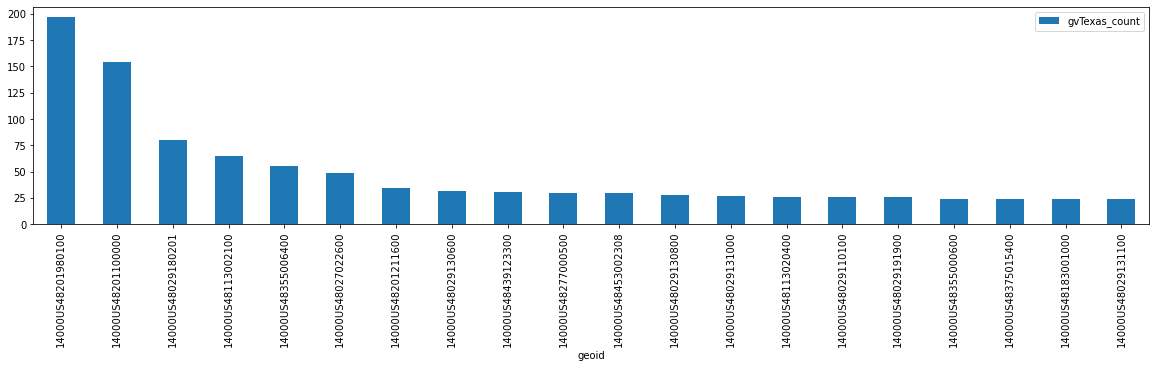

In [78]:
gvTexas_by_texasPop[:20].plot.bar(figsize=(20,4),
                             x='geoid',
                             y='gvTexas_count')

now we will join the summary table back to the pop. data

In [79]:
texasPop = texasPop.merge(gvTexas_by_texasPop,on='geoid')

and check again

In [80]:
texasPop.head()

,geoid,name,Total,geometry,gvTexas_count
0,14000US48001950100,"Census Tract 9501, Anderson, TX",4844.0,"MULTIPOLYGON (((-10652944.093 3760156.467, -10...",1
1,14000US48001950500,"Census Tract 9505, Anderson, TX",4465.0,"MULTIPOLYGON (((-10651904.926 3738450.297, -10...",5
2,14000US48001950600,"Census Tract 9506, Anderson, TX",5148.0,"MULTIPOLYGON (((-10654136.436 3727343.837, -10...",4
3,14000US48001950700,"Census Tract 9507, Anderson, TX",2783.0,"MULTIPOLYGON (((-10647654.414 3730603.857, -10...",9
4,14000US48001950800,"Census Tract 9508, Anderson, TX",5505.0,"MULTIPOLYGON (((-10645350.657 3731416.708, -10...",2


normalize the data and add a new column for the number of gun violence incidents per 1000

In [81]:
texasPop['gvTexas_per_1000'] = texasPop['gvTexas_count']/texasPop['Total']*1000

check again!

In [82]:
texasPop.sort_values(by="gvTexas_per_1000").tail()

,geoid,name,Total,geometry,gvTexas_count,gvTexas_per_1000
2417,14000US48303000700,"Census Tract 7, Lubbock, TX",975.0,"MULTIPOLYGON (((-11338474.119 3972266.960, -11...",20,20.512821
2415,14000US48303000605,"Census Tract 6.05, Lubbock, TX",841.0,"MULTIPOLYGON (((-11339224.747 3974200.268, -11...",19,22.592152
1419,14000US48201100000,"Census Tract 1000, Harris, TX",6011.0,"MULTIPOLYGON (((-10617052.129 3472431.021, -10...",154,25.619697
695,14000US48113002100,"Census Tract 21, Dallas, TX",2338.0,"MULTIPOLYGON (((-10777023.915 3866292.111, -10...",65,27.801540
2083,14000US48201980100,"Census Tract 9801, Harris, TX",519.0,"MULTIPOLYGON (((-10617664.164 3506168.743, -10...",197,379.576108


We will now be using the KNN library and we will set k=8 to account for surrounding neighbors to determine the spatial weight of gun violence in Texas. Then we do row standardization to adjust the nearest neighbor weight in a spatial weight matrix



In [83]:
wq = lps.weights.KNN.from_dataframe(texasPop,k=8)
wq.transform = 'r'

We will now be creating a new column for the average of the “r” value to create a single value

In [84]:
texasPop['gvTexas_per_1000_lag'] = lps.weights.lag_spatial(wq, texasPop['gvTexas_per_1000'])

create new column that calculates the difference between gun violence data and spatial lag

In [85]:
texasPop['gvtexas_lag_diff'] = texasPop['gvTexas_per_1000'] - texasPop['gvTexas_per_1000_lag']

check the first and last 5 rows

In [86]:
texasPop.sort_values(by='gvtexas_lag_diff')

,geoid,name,Total,geometry,gvTexas_count,gvTexas_per_1000,gvTexas_per_1000_lag,gvtexas_lag_diff
1520,14000US48201240902,"Census Tract 2409.02, Harris, TX",16658.0,"MULTIPOLYGON (((-10609743.225 3504316.612, -10...",3,0.180094,48.039673,-47.859580
1511,14000US48201240400,"Census Tract 2404, Harris, TX",8300.0,"MULTIPOLYGON (((-10620411.640 3506356.838, -10...",6,0.722892,48.297036,-47.574145
1519,14000US48201240901,"Census Tract 2409.01, Harris, TX",11399.0,"MULTIPOLYGON (((-10612099.302 3505045.631, -10...",9,0.789543,48.019157,-47.229615
1518,14000US48201240802,"Census Tract 2408.02, Harris, TX",6859.0,"MULTIPOLYGON (((-10620483.998 3507550.143, -10...",6,0.874763,47.885970,-47.011207
1528,14000US48201241500,"Census Tract 2415, Harris, TX",7911.0,"MULTIPOLYGON (((-10618056.788 3497036.165, -10...",13,1.643282,48.130228,-46.486946
...,...,...,...,...,...,...,...,...
2687,14000US48355006400,"Census Tract 64, Nueces, TX",2687.0,"MULTIPOLYGON (((-10844359.628 3223622.368, -10...",55,20.468924,3.949466,16.519458
2415,14000US48303000605,"Census Tract 6.05, Lubbock, TX",841.0,"MULTIPOLYGON (((-11339224.747 3974200.268, -11...",19,22.592152,4.421124,18.171028
1419,14000US48201100000,"Census Tract 1000, Harris, TX",6011.0,"MULTIPOLYGON (((-10617052.129 3472431.021, -10...",154,25.619697,1.806920,23.812777
695,14000US48113002100,"Census Tract 21, Dallas, TX",2338.0,"MULTIPOLYGON (((-10777023.915 3866292.111, -10...",65,27.801540,1.467431,26.334109


## Moran's Plot
Now we will quantify the degree of the spatial correlations using Moran's Plot

In [88]:
y = texasPop.gvTexas_per_1000
moran = Moran(y, wq)
moran.I

0.010816472422853688

It seems our Moran value is 0.012 which is a  positive value which means there is a positive spatial autocorrelation. 

now we output a scatter plot of our "gun violence data per 1000" and "gun violence data per 1000 spatial lag" in Texas

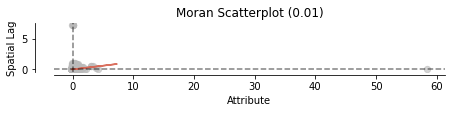

In [89]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

We will now compare our observed Moran’s I value to this reference distribution

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f41f8294dc0>)

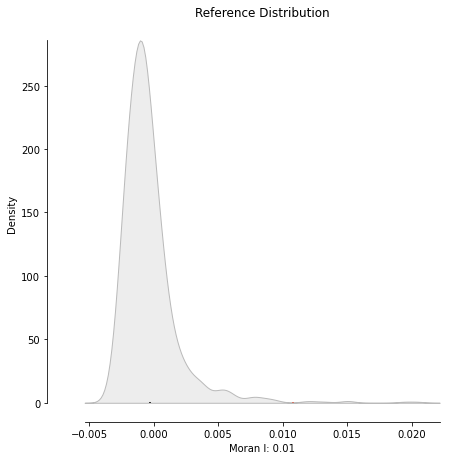

In [90]:
plot_moran_simulation(moran,aspect_equal=False)

In [91]:
moran.p_sim

0.008

Looking at the distribution above and the calculated P value of 0.008, we can determine that only 0.8% of Moran’s statistic would be larger than the one calculated (0.012). Proving that the correlation is high enough to be predictable.

calculate local moran values

In [92]:
lisa = esda.moran.Moran_Local(y, wq)

now we plot and add some arguments for the labels for our moran local scatterplot. using lisa to detect clusters for the correlation in neighborhood quality and our gun data, we can discern the high values near to high values (HH), low values with nearby low values (LL), low values with high values in its neighborhood (& vice-versa)

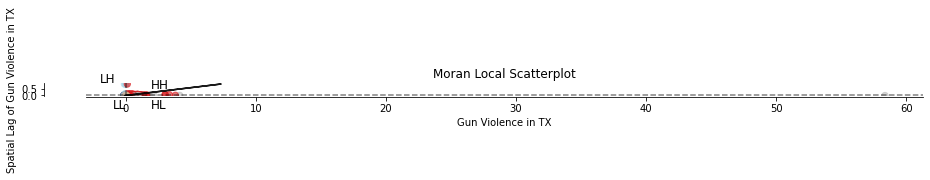

In [101]:
fig,ax = plt.subplots(figsize=(15,300))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Gun Violence in TX")
ax.set_ylabel('Spatial Lag of Gun Violence in TX')

plt.text(1.95, 0.5, "HH", fontsize=12)
plt.text(1.95, -1, "HL", fontsize=12)
plt.text(-2, 1, "LH", fontsize=12)
plt.text(-1, -1, "LL", fontsize=12)
plt.show()

judging by the visualization there are clusters but they are not high in spatial lag, there is a relatively high correlation proving the gun violence incidents are not entirely located randomly

using the lisa_cluster function we can map the clusters

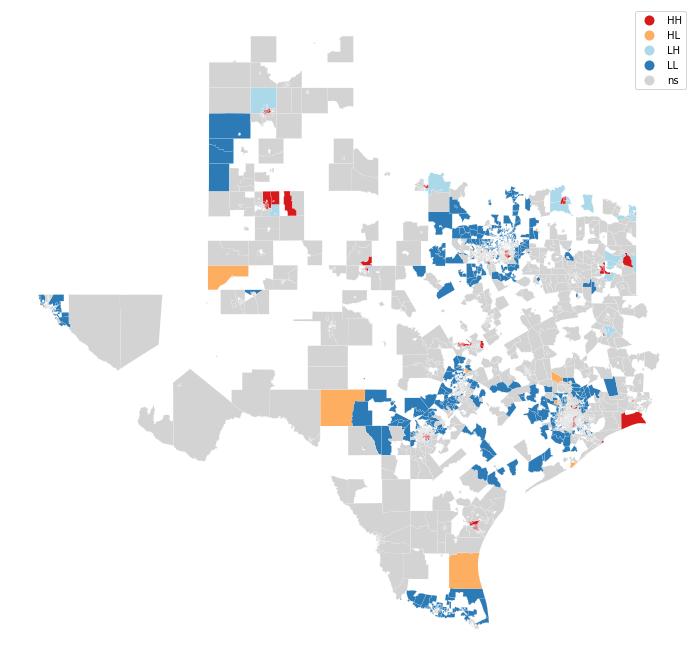

In [94]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, texasPop, p=0.05, ax=ax)
plt.show()

From this visualizations we see collections of LL areas and HH areas proving like areas surround like areas. However there are some diamonds, which are high incident census tracts bordered by low incident census tracts.